# Mask Detection Model Utilizing CNN

## 배경
- 코로나 시대에 접어들면서 마스크를 쓰는게 거의 필수가 되었습니다. 이에 따라 예상치 못한 상황과 문제점들이 발생하게 되었습니다.
- 예를 들어 Iphone을 unlock하는데 사용되는 얼굴 인식 기술은 코로나가 생기면서 오히려 불편함을 일으키게 되었습니다. 그 이유는 모든 사람들이 마스크를 써야하는 상황이 발생했으나 Iphone 얼굴 인식기는 마스크를 낀 사람들의 얼굴을 제대로 인식할 수가 없다는게 확인 되어서입니다. 
- 또한 마스크를 써야하는 장소에서 사람들이 몰래 쓰지 않는 경우들이 국내에서도 가끔 확인되며 외국에는 특히 많은 것으로 보입니다. 

## 목적
- Iphone 얼굴 인식을 할때 마스크를 쓴 자와 마스크를 쓰지 않은 자를 먼저 구별하고 각자에 맞는 인식 알고리즘 적용할 수 있도록 마스크 Detection 모델 구현해봤습니다. 마스크를 쓰지 않은 자는 기존 잘 활용되었던 Iphone 얼굴 인식 기술을 사용하면 되고, 마스크를 쓴 자는 별도의 인식 기술을 사용하면 된다고 생각했습니다. 
- 또한 마스크를 껴야하는 공공장소에 체온 측정만 하는게 아니라, 마스크를 알맞게 착용했는지 자동 검수할 수 있는 시스템 구축하는 것을 생각했스빈다. 

## 주요 기능
- 사람 얼굴이 나오는 이미지를 줬을때, 그 사람이 마스크를 섰는지 안섰는지 구별

## 데이터 획득 및 처리
- Kaggle에서 데이터 수집: https://www.kaggle.com/omkargurav/face-mask-dataset
- 해당 데이터를 local 환경에서 다운받아, 원하는 directory 형태로 변경한 후 압축하여, Colab에 업로드했습니다. 이때 directory는 training set, validation set으로 구분하여 저장했습니다. 
- Colab의 특징상 일정 기간이 지나면 해당 압축 파일은 사라지게 됩니다. 채점하게 되는 기간에 채점자가 업로드 요청드리면 다시 업로드하면 된다고 교수님께 메일을 통해 안내 받아 요청주시면 다시 업로드하도록 하겠습니다. 
- zip 형태가 아니라 Google Drive으로 업로드하는 형태로도 시도를 하였으나 학습하는데 너무 오랜 시간이 걸리는 것으로 확인되어 zip 형태로 업로드 하는 방식을 선택했습니다. 

## 모델 & 구현 방법
- 이미지 인식할 수 있는 CNN 모델을 활용했습니다. 
- 이미지들을 학습할 수 있는 형태로 먼저 데이터 변경했습니다. 
- 모델은 복수 hidden layer를 넣었다 빼면서 여러번 테스트를 진행하면서 가장 적합한 형태로 최종 정리해봤습니다. 그 이후 compile은 adam을 사용했으며 loss는 sparse categorical cross entropy를 활용했습니다.
- 학습할때 overfitting 방지를 위해 early stop할 수 있는 코드를 추가하여 학습을 돌려봤습니다. 
- epoch는 처음에는 넉넉하게 30개를 넣어서 돌려봤으며, 적당한 숫자로 줄여 조율하여 정했습니다. 

## 결과 요약
- 정확도는 약 93%로 마스크 여부를 판단할 수 있었습니다. 



In [ ]:
## local에서 업로드하고 unzip해서 데이터 업로드
!unzip /content/mask_data.zip

In [ ]:
import numpy as np 
import pandas as pd 
import os

## Fit the Images

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# getting data
base_dir = 'mask_data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [ ]:
train_dir

'mask_data/train'

In [ ]:
validation_dir

'mask_data/validation'

In [ ]:
train_with_mask = os.path.join(train_dir, 'with_mask')
train_without_mask = os.path.join(train_dir, 'without_mask')

In [ ]:
validation_with_mask = os.path.join(validation_dir, 'with_mask')
validation_without_mask = os.path.join(validation_dir, 'without_mask')

In [ ]:
num_mask_tr = len(os.listdir(train_with_mask))
num_without_mask_tr = len(os.listdir(train_without_mask))
num_mask_val = len(os.listdir(validation_with_mask))
num_without_mask_val = len(os.listdir(validation_without_mask))

In [ ]:
total_train = num_mask_tr + num_without_mask_tr
total_val = num_mask_val + num_without_mask_val

BATCH_SIZE = 32
IMG_SHAPE = 150 # square image. 150x150 pixel

## Create Image Generator

In [ ]:
## to show image
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

In [ ]:
validation_image_generator = ImageDataGenerator(
    rescale=1./255)

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True, ## random
                                                           target_size=(IMG_SHAPE, IMG_SHAPE),
                                                           class_mode='binary')

Found 7153 images belonging to 2 classes.


In [ ]:
val_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=validation_dir,
                                                           shuffle=False,## not random
                                                           target_size=(IMG_SHAPE, IMG_SHAPE),
                                                           class_mode='binary')

Found 400 images belonging to 2 classes.


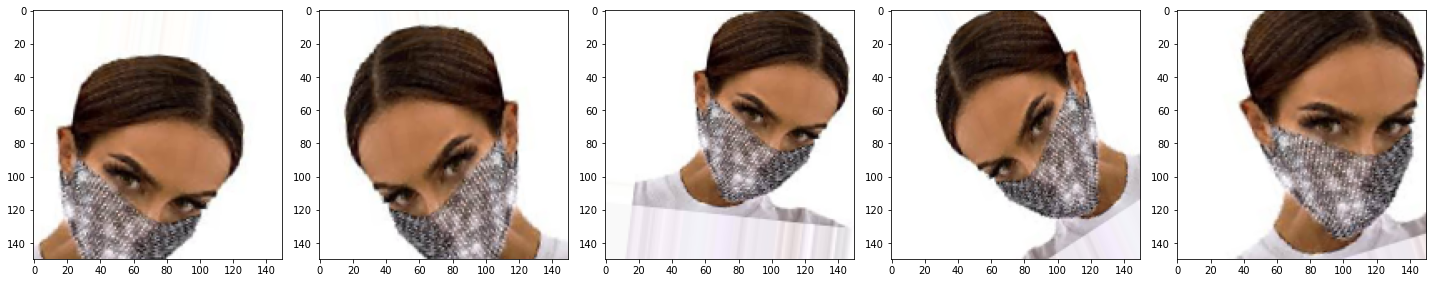

In [ ]:
images = [train_data_gen[0][0][1] for i in range(5)]
plotImages(images)

## Train Model

In [ ]:
## overfitting 막기
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=25)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)), # RGB
    tf.keras.layers.MaxPooling2D(2,2),  
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

In [ ]:
history = model.fit(train_data_gen, epochs=16, callbacks=[early_stop])

Epoch 1/16
 34/224 [===>..........................] - ETA: 52s - loss: 1.2236 - accuracy: 0.5415

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


224/224 [==============================] - 63s 278ms/step - loss: 0.5634 - accuracy: 0.7563
Epoch 2/16
224/224 [==============================] - 62s 276ms/step - loss: 0.4098 - accuracy: 0.8226
Epoch 3/16
224/224 [==============================] - 62s 276ms/step - loss: 0.3733 - accuracy: 0.8388
Epoch 4/16
224/224 [==============================] - 61s 274ms/step - loss: 0.3562 - accuracy: 0.8458
Epoch 5/16
224/224 [==============================] - 62s 274ms/step - loss: 0.3475 - accuracy: 0.8485
Epoch 6/16
224/224 [==============================] - 61s 273ms/step - loss: 0.3278 - accuracy: 0.8588
Epoch 7/16
224/224 [==============================] - 61s 271ms/step - loss: 0.3103 - accuracy: 0.8668
Epoch 8/16
224/224 [==============================] - 61s 271ms/step - loss: 0.3009 - accuracy: 0.8715
Epoch 9/16
224/224 [==============================] - 60s 269ms/step - loss: 0.2871 - accuracy: 0.8801
Epoch 10/16
224/224 [==============================] - 61s 270ms/step - loss: 0.2715

In [ ]:
model.evaluate(val_data_gen)

13/13 [==============================] - 3s 204ms/step - loss: 0.2021 - accuracy: 0.9325


[0.20206233859062195, 0.9325000047683716]

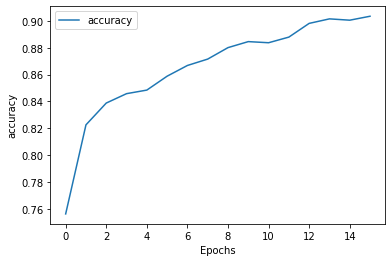

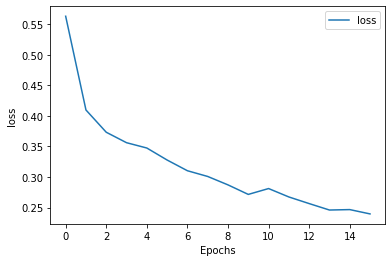

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")